In [1]:
import arviz as az
import numpy as np  # For vectorized math operations

import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt
from scipy.stats import gumbel_r
import seaborn as sns
from matplotlib import pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format='retina'

sns.set_theme(
    context="notebook",
    style="white",
    font="Latin Modern Roman",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False,
        "text.usetex": True,
    },
)

extra_params = {
    "text.latex.preamble": " ".join([r"\usepackage{mathtools}", r"\usepackage{amssymb}"])
}

plt.rcParams.update(extra_params)

# Introduction

Data generating process is:
$$
u_{ij} = {\alpha_{ij}} + {x_j}'\beta^{\text{feature}}_{i} + \eta_{ij} - \eta_{i0}
$$
where
- the consumer knows $\left(\alpha_{ij}, x_j, \beta^{\text{feature}}_{i}, \eta_{ij}\right)$, which implies outcome variables $\left(j^{(1)}_i,\, \ldots\right)$
- the econometrician knows $\left(x_j, j^{(1)},\,\ldots \right)$ and has priors over $\left(\alpha, \beta^{\text{feature}}\right)$
- neither the consumer nor the econometrician knows $\eta_{i0}$, but they have common priors

Consumer reports
- their preferred "inside" good $j^{(1)}$

Depending on the setup, the consumer either reports
- their preferred "overall" good $k^{(1)}$
- the probability they purchase the good on a Likert scale with $W$ categories

## Notation

- $N$ is the number of individuals
- $J$ is the number of products
- $K$ is the number of product attributes
- $M$ is the number of individual attributes
- $W$ is the number of categories on the Likert scale

### Simulate Data

In [3]:
def basic_model(params, draws):
    J = params["J"]
    K = params["K"]
    N = params["N"]

    u = np.ones((N, 1)) @ draws["α_j"].reshape((1, -1)) + draws["product_features"] @ draws["β_k"] + draws["η"]

    # jstar = np.argmax(u[:, :-1], axis=1)
    # kstar = np.argmax(u, axis=1)

    return draws | {
        "utilities": u,
        "α_j": draws["α_j"],
        "β_k": draws["β_k"],
    }


def random_coefficient_model(params, draws):
    J = params["J"]
    K = params["K"]
    N = params["N"]

    α_ij = np.ones((N, 1)) @ draws["α_j"].reshape((1, -1)) + np.random.normal(0, 1, (N, J+1))
    α_ij[:, -1] = 0
    β_ik = np.ones((N, 1)) @ draws["β_k"].reshape((1, -1)) + np.random.normal(0, 1, (N, K))

    u = α_ij + np.sum(draws["product_features"] * β_ik.reshape(N, 1, K), axis=2) + draws["η"]

    # jstar = np.argmax(u[:, :-1], axis=1)
    # kstar = np.argmax(u, axis=1)

    return draws | {
        "utilities": u,
        "α_j": draws["α_j"],
        "β_k": draws["β_k"],
        "α_ij": α_ij,
        "β_ik": β_ik,
    }

dgp = {
    "homogeneous": basic_model,
    "heterogeneous": random_coefficient_model, # add more DGPs here
}

def simulate_dgps(params):

    ## load parameters
    # M = params["M"]
    W = params["W"]
    J = params["J"]
    K = params["K"]
    N = params["N"]

    np.random.seed(42)
    
    # draw product features to be same across all DGPs
    
    product_features = np.random.normal(0, 0.2, (N, J, K))
    product_features = np.concatenate(
        [product_features, np.zeros((N, 1, K))], axis=1
    )  # outside good

    # draw latent preference parameters to be comparable across all DGPs

    α_j = np.random.normal(-2, 1, J+1)
    β_k = np.random.normal(0, 1, K)
    α_j[-1] = 0 # outside good
    
    π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
    η = np.random.gumbel(0, 1, (N, J + 1))
    
    draws = {
        "α_j": α_j,
        "β_k": β_k,
        "π": π,
        "η": η,
        "product_features": product_features
    }

    # d = {
    #     "product_features": product_features,
    # }

    d = {k: dgp[k](params, draws) for k in dgp}
    # for k in dgp:
    #     d[f"dgp{k}"] = dgp[k](params, draws)
        
    return d

def basic_conjoint(dgp):
    u = dgp["utilities"]
    
    # jstar = np.argmax(u[:, :-1], axis=1)
    kstar = np.argmax(u, axis=1)
    
    return {
        "product_features": dgp["product_features"],
        "kstar": kstar, #preferred overall good
    }

def dual_response_conjoint(dgp):
    u = dgp["utilities"]
    
    jstar = np.argmax(u[:, :-1], axis=1)
    kstar = np.argmax(u, axis=1)
    
    return {
        "product_features": dgp["product_features"],
        "jstar": jstar, #preferred inside good
        "kstar": kstar, #preferred overall good
    }

def likert_dual_conjoint(dgp):
    u = dgp["utilities"]
    jstar = np.argmax(u[:, :-1], axis=1)
    v = np.max(u[:, :-1], axis=1)
    w = np.digitize(gumbel_r.cdf(v), dgp["π"])

    return {
        "product_features": dgp["product_features"],
        "jstar": jstar,  # preferred inside good
        "w": w,  # likert bucket
    }


generate_observables = {
    "basic_conjoint": basic_conjoint,
    "dual_response_conjoint": dual_response_conjoint,
    "likert_dual_conjoint": likert_dual_conjoint,
}

params = {"N": 200, "J": 3, "K": 5, "M": 2, "W": 4}

dgps = simulate_dgps(params)

### Export Data

In [4]:
# out_data1 = np.array(
#     [
#         [n, j, 0, data["t"][n] == j, *data["product_features"][n, j, :]]
#         for n in range(params["N"])
#         for j in range(params["J"] + 1)
#     ]
# )

# out_data2 = np.array(
#     [
#         [
#             n,
#             j,
#             1, 
#             data["jstar"][n] == j,
#             *data["product_features"][n, j, :],
#             data["jstar"][n] == data["t"][n],
#         ]
#         for n in range(params["N"])
#         for j in range(params["J"])
#     ]
# )
# out_data = np.concatenate([out_data1, out_data2[out_data2[:, -1] == 0, :-1]], axis=0)
# pd.DataFrame(
#     out_data,
#     columns=[
#         "consumer_id",
#         "choice_id",
#         "task_id",
#         "purchase",
#         *[f"f_{k}" for k in range(params["K"])],
#     ],
# ).to_csv("/Users/gzheng/Desktop/data.csv", index=False)

# Representative Consumer Preferences

In [5]:
data = generate_observables["basic_conjoint"](dgps["homogeneous"])

### Visualize the Data

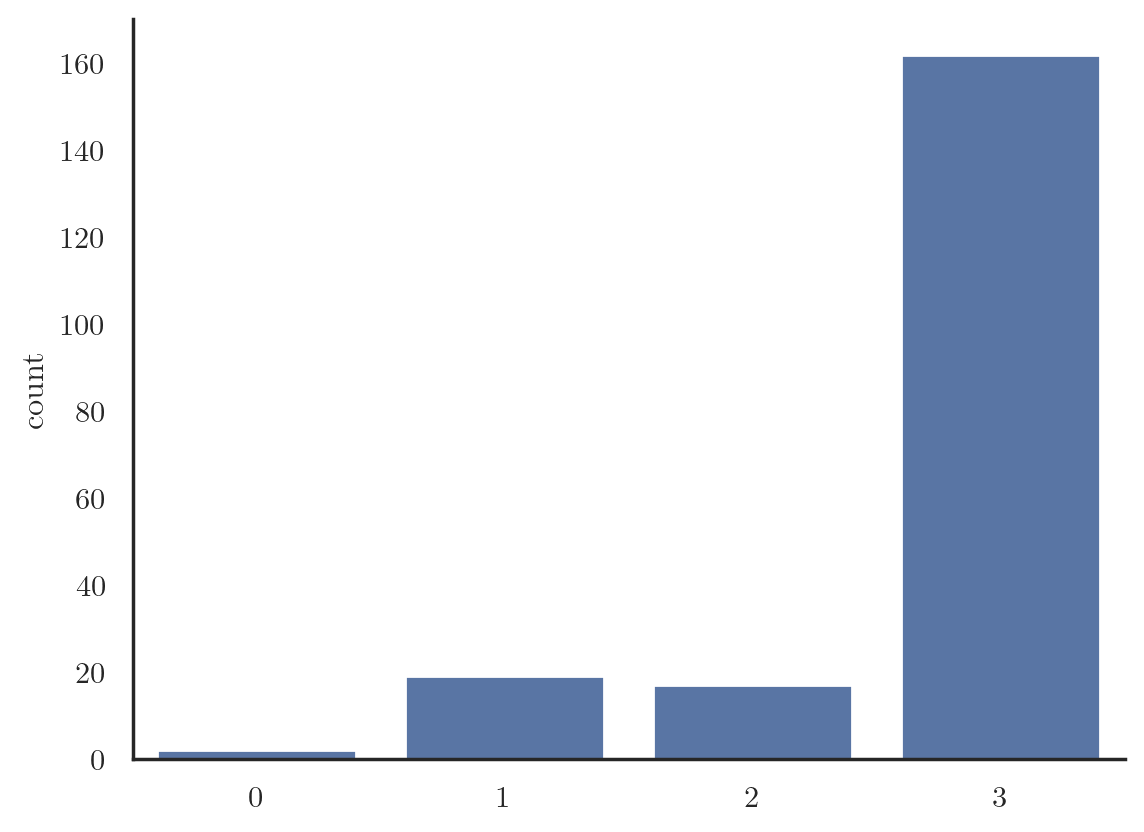

In [6]:
# sns.countplot(x=data["jstar"])
sns.countplot(x=data["kstar"])
# plt.legend(title="Survey Response", labels=["Preferred Inside Good", "Preferred Overall Good"])
plt.show()

## Classic Multinomial Logit

First, try "classical" conjoint, in which $\eta_0$ is observed by the consumer.

### Construct the Model

In [7]:
observed_good = data["kstar"]

N = params["N"]
M = params["M"]
J = params["J"]
K = params["K"]
W = params["W"]
# J, K = data["product_features"].shape
# W = len(np.unique(observed_bin))


coords_1 = {
    "products": [f"product_{i}" for i in range(J + 1)],
    "i_factors": [f"if_{i}" for i in range(M)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

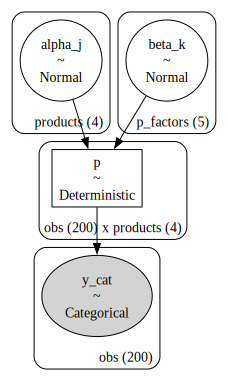

In [8]:
with pm.Model(coords=coords_1) as model_1:

    # mu_α_p = pm.Normal("mu_α_p", 0, 1)
    # sigma_α_p = pm.HalfCauchy("sigma_α_p", 1)

    # alpha_p = pm.Normal("alpha_j", mu_α_p, sigma_α_p, dims=["products"])
    # alpha_p = pt.set_subtensor(alpha_p[-1], 0) #outside good

    # mu_β_p = pm.Normal("mu_β_p", 0, 1)
    # sigma_β_p = pm.HalfCauchy("sigma_β_p", 1)

    alpha_p = pm.Normal("alpha_j", 0, 5, dims=["products"])
    alpha_p = pt.set_subtensor(alpha_p[-1], 0) #outside good

    # beta_p = (
    #     pm.math.ones((N, 1))
    #     * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
    # )  # want there to be N*K beta's

    beta_p = pm.Normal("beta_k", 0, 5, dims=["p_factors"])

    ## Construct Utility matrix

    # beta_p_print = Print("beta_p")(beta_p)

    s = pm.math.ones((N, 1)) @ alpha_p.reshape((1, -1)) + data["product_features"] @ beta_p

    # s_print = Print("s")(s)
    # s = beta_p @ data["product_features"].T
    # s = pm.math.concatenate([s_good, np.zeros((N, 1))], axis=1)

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")

pm.model_to_graphviz(model_1)

### Estimate the Model

In [9]:
with model_1:
    # idata_m1 = pm.sample_prior_predictive()
    # idata_m1.extend(
    #     pm.sample(
    #         5000,
    #         nuts_sampler="numpyro",
    #         idata_kwargs={"log_likelihood": True},
    #         random_seed=100,
    #     )
    # )
    # idata_m1.extend(pm.sample_posterior_predictive(idata_m1))
    idata_m1 = pm.sample(
        5000,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=100,
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [10]:
# from IPython.display import display

# with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
#     display(az.summary(idata_m1, var_names=["~p"]).loc[lambda _df: _df['ess_tail'] < 1_000])

In [11]:
az.summary(idata_m1, var_names=["~p"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_j[product_0],-4.914,0.768,-6.367,-3.565,0.005,0.004,29507.0,13539.0,1.0
alpha_j[product_1],-2.541,0.284,-3.060,-1.993,0.002,0.001,24433.0,15479.0,1.0
alpha_j[product_2],-2.609,0.294,-3.168,-2.069,0.002,0.001,24912.0,15291.0,1.0
alpha_j[product_3],0.061,5.010,-9.691,9.171,0.025,0.040,39735.0,14779.0,1.0
beta_k[pf_0],0.078,0.872,-1.555,1.728,0.004,0.007,38347.0,15748.0,1.0
beta_k[pf_1],-2.413,0.831,-4.011,-0.891,0.005,0.004,31647.0,14882.0,1.0
beta_k[pf_2],1.137,0.883,-0.525,2.772,0.005,0.004,34739.0,15496.0,1.0
beta_k[pf_3],-1.539,0.941,-3.325,0.193,0.005,0.004,32988.0,16482.0,1.0
beta_k[pf_4],2.388,0.859,0.760,3.988,0.005,0.004,27963.0,16346.0,1.0


In [12]:
post1 = az.extract(idata_m1)

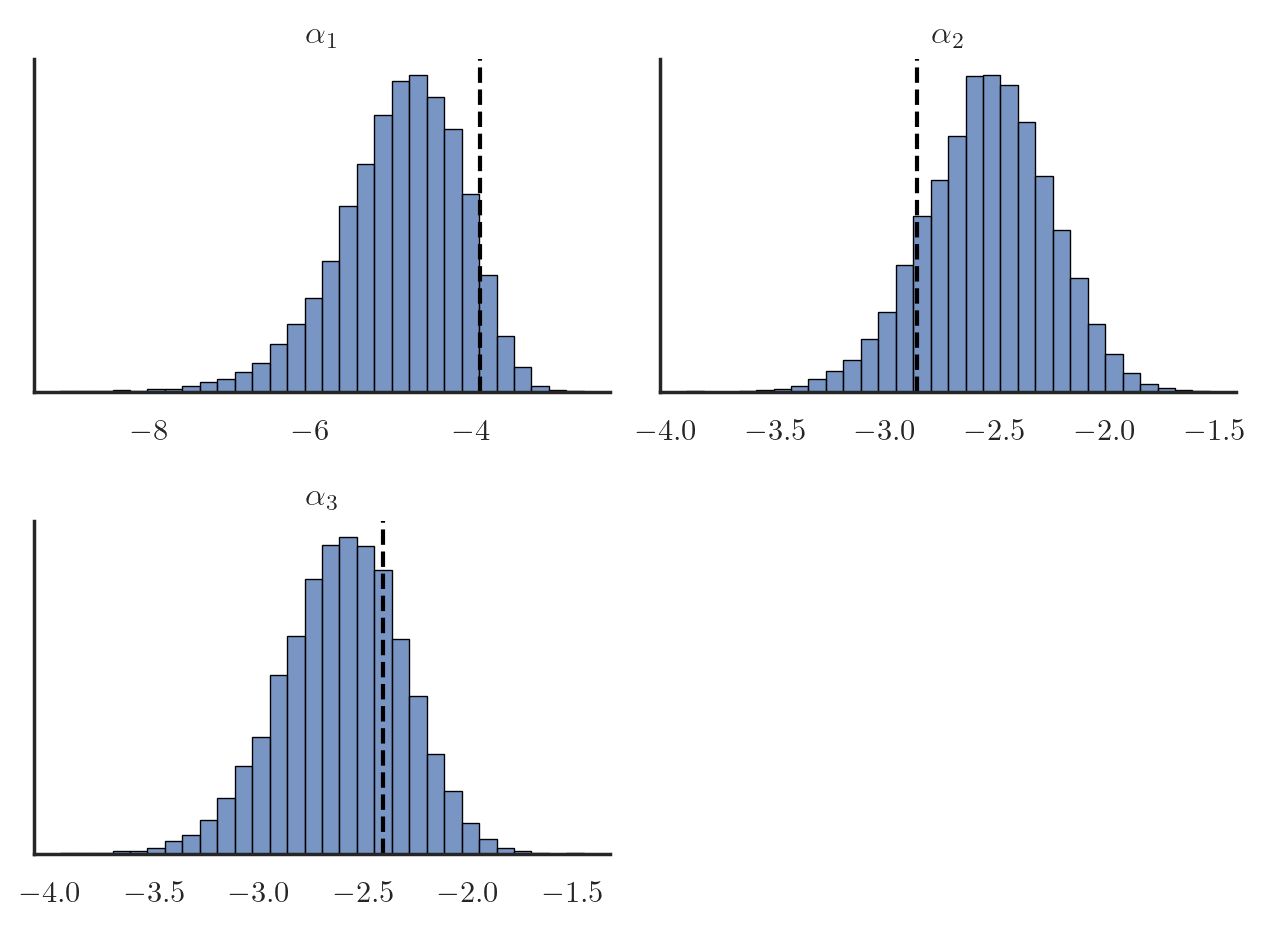

In [13]:
fig, axs = plt.subplots(J // 2 + J % 2, 2)

for i in range((J // 2 + J % 2)*2):
    plt.sca(axs.flatten()[i])
    if i >= J:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post1["alpha_j"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(dgps["homogeneous"]["α_j"][i], linestyle="dashed", color="black")
    plt.title(rf"$\alpha_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

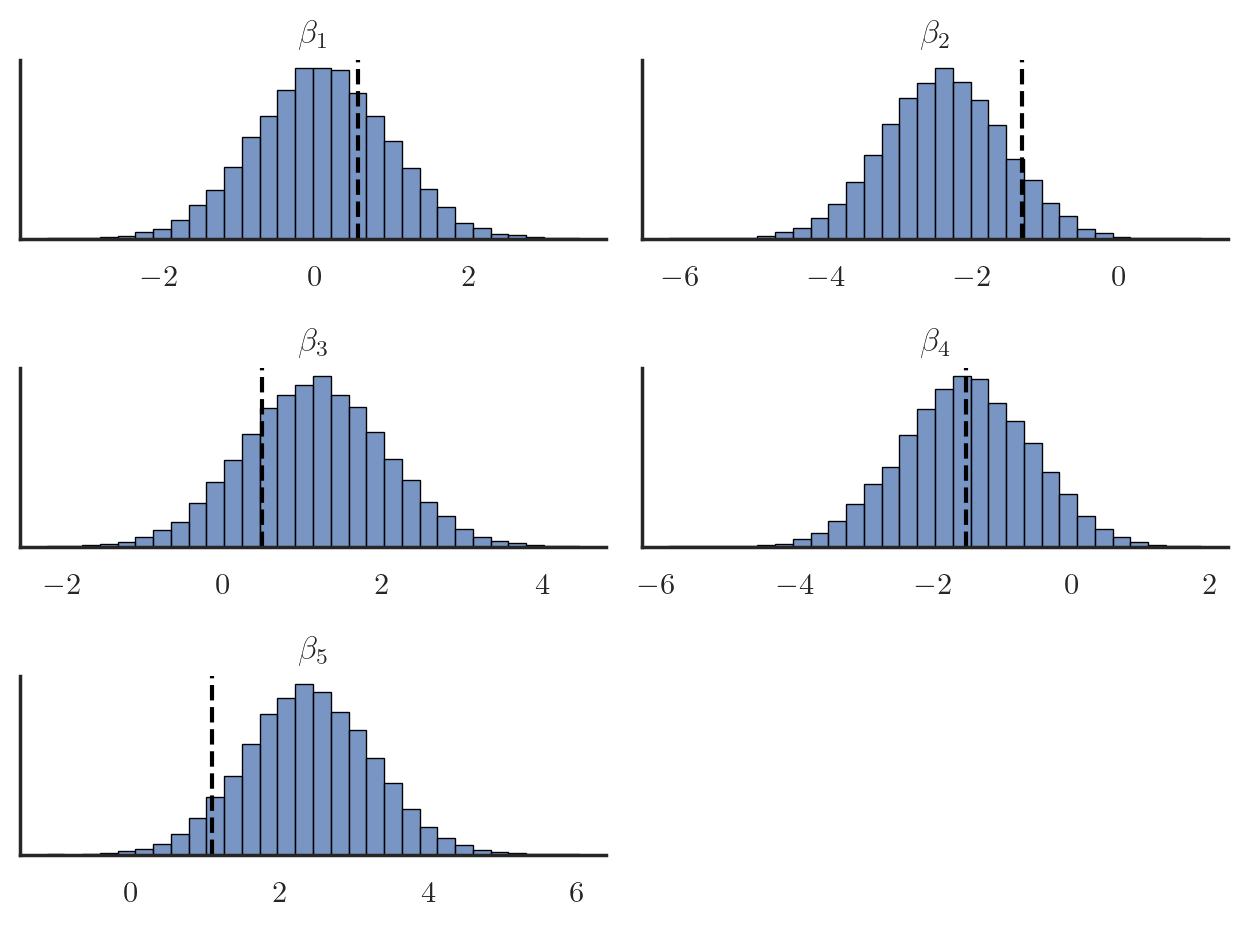

In [14]:
fig, axs = plt.subplots(K // 2 + K % 2, 2)

for i in range((K // 2 + K % 2)*2):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post1["beta_k"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(dgps["homogeneous"]["β_k"][i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

## Dual Response (Logit)

In [15]:
data = generate_observables["dual_response_conjoint"](dgps["homogeneous"])

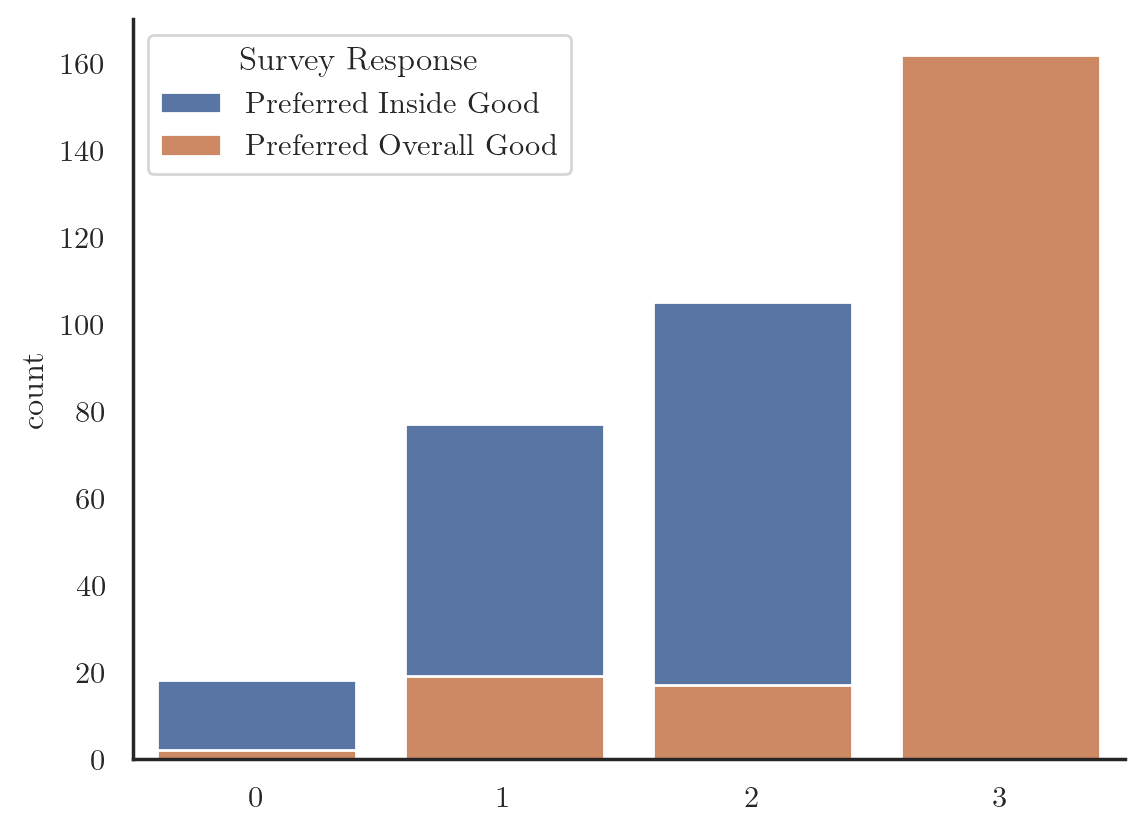

In [16]:
sns.countplot(x=data["jstar"])
sns.countplot(x=data["kstar"])
plt.legend(title="Survey Response", labels=["Preferred Inside Good", "Preferred Overall Good"])
plt.show()

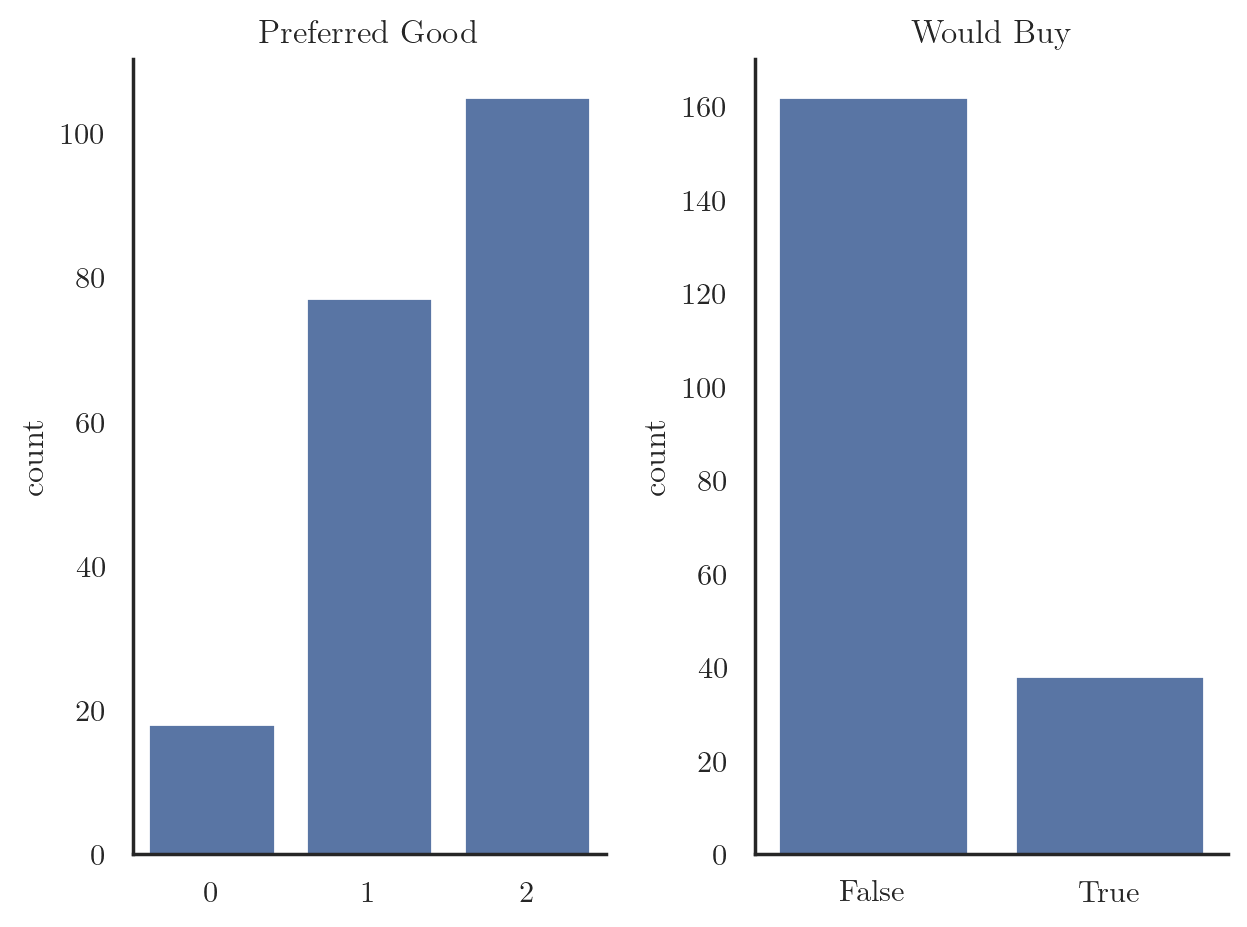

In [17]:
fig, axs = plt.subplots(1, 2)
sns.countplot(x=data["jstar"], ax=axs[0]).set(title="Preferred Good")
sns.countplot(x=data["jstar"]==data["kstar"], ax=axs[1]).set(title="Would Buy")
# plt.legend(title="Survey Response", labels=["Preferred Inside Good", "Would Buy"])
plt.tight_layout()
plt.show()

### Construct the Model

In [18]:
observed_inside = data["jstar"]
observed_buy = data["kstar"] == data["jstar"]

N = params["N"]
J = params["J"]
K = params["K"]

coords_2 = {
    "products": [f"product_{j}" for j in range(J)],
    "p_factors": [f"feature_{k}" for k in range(K)],
    "obs": range(N),
}

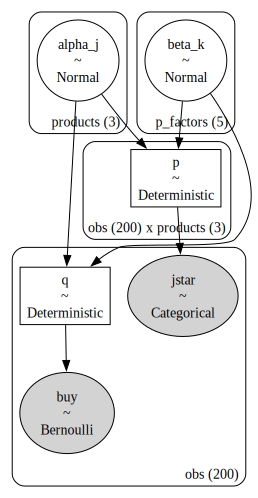

In [19]:
with pm.Model(coords=coords_2) as model_2:

    # mu_α_p = pm.Normal("mu_α_p", 0, 1)
    # sigma_α_p = pm.Exponential("sigma_α_p", 1)

    alpha_p = pm.Normal("alpha_j", 0, 5, dims=["products"])
    
    # mu_β_p = pm.Normal("mu_β_p", 0, 1)
    # sigma_β_p = pm.Exponential("sigma_β_p", 1)
    
    beta_p = pm.Normal("beta_k", 0, 5, dims=["p_factors"])

    ## Construct Utility matrix

    s = pm.math.ones((N, 1)) @ alpha_p.reshape((1, -1)) + data["product_features"][:, :-1, :] @ beta_p

    ## Construct Probabilities
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))
    q_ = pm.Deterministic("q", pm.math.log(pm.math.sum(pm.math.exp(s), axis=1)), dims="obs")
    
    ## Likelihood
    choice_obs = pm.Categorical("jstar", p=p_, observed=observed_inside, dims="obs")
    bin_obs = pm.Bernoulli("buy", logit_p = q_, observed=observed_buy, dims="obs")

pm.model_to_graphviz(model_2)

### Estimate the Model

In [20]:
with model_2:
    idata_m2 = pm.sample(
        5000,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=100,
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

### Visualize the Estimates

In [21]:
az.summary(idata_m2, var_names=["~p", "~q"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_j[product_0],-4.216,0.318,-4.812,-3.625,0.003,0.002,15488.0,15498.0,1.0
alpha_j[product_1],-2.661,0.216,-3.048,-2.237,0.002,0.001,13866.0,14849.0,1.0
alpha_j[product_2],-2.292,0.204,-2.672,-1.911,0.002,0.001,14255.0,15026.0,1.0
beta_k[feature_0],1.126,0.458,0.256,1.972,0.003,0.002,28072.0,15204.0,1.0
beta_k[feature_1],-1.888,0.473,-2.812,-1.040,0.003,0.002,28251.0,15621.0,1.0
beta_k[feature_2],1.049,0.487,0.146,1.966,0.003,0.002,28537.0,15082.0,1.0
beta_k[feature_3],-1.563,0.525,-2.542,-0.569,0.003,0.002,29330.0,15135.0,1.0
beta_k[feature_4],1.447,0.487,0.540,2.365,0.003,0.002,24642.0,14988.0,1.0


In [22]:
post2 = az.extract(idata_m2)

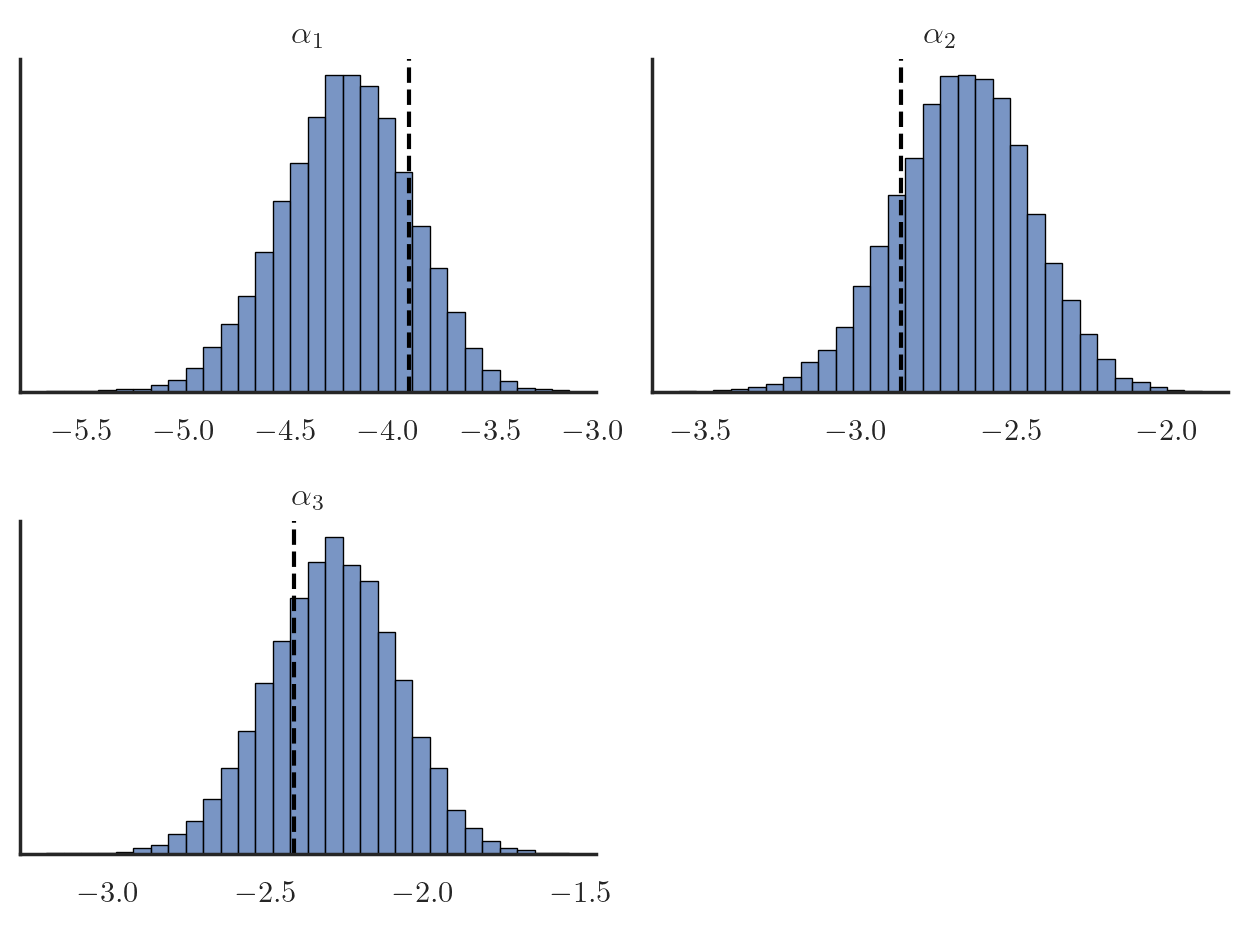

In [23]:
fig, axs = plt.subplots( J // 2 + J % 2, 2)

for i in range((J // 2 + J % 2)*2):
    plt.sca(axs.flatten()[i])
    if i >= J:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post2["alpha_j"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(dgps["homogeneous"]["α_j"][i], linestyle="dashed", color="black")
    plt.title(rf"$\alpha_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

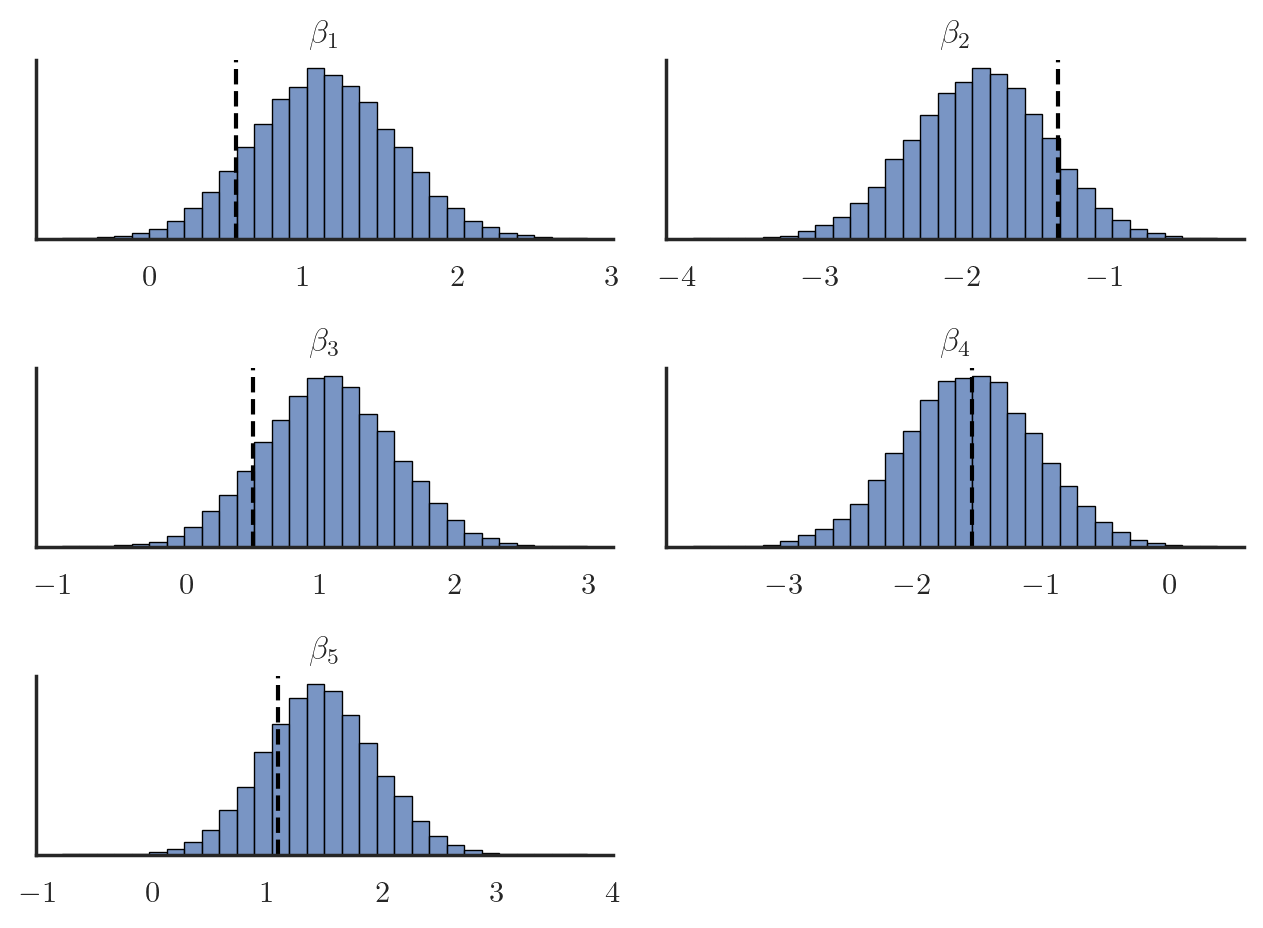

In [24]:
fig, axs = plt.subplots(K // 2 + K % 2, 2)

for i in range((K // 2 + K % 2) * 2):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post2["beta_k"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(dgps["homogeneous"]["β_k"][i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

## Dual Response (Synthetic Data)

In [25]:
data = generate_observables["dual_response_conjoint"](dgps["homogeneous"])

### Construct the "Synthetic Data" Model

In [26]:
observed_inside = data["jstar"]
observed_good = data["kstar"]

N = params["N"]
J = params["J"]
K = params["K"]

coords_3 = {
    "products": [f"product_{j}" for j in range(J+1)],
    "p_factors": [f"feature_{k}" for k in range(K)],
    "obs": range(N),
}

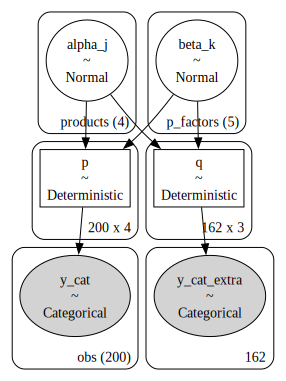

In [27]:
with pm.Model(coords=coords_3) as model_3:

    # mu_α_p = pm.Normal("mu_α_p", 0, 1)
    # sigma_α_p = pm.Exponential("sigma_α_p", 1)

    alpha_p = pm.Normal("alpha_j", 0, 5, dims=["products"])
    alpha_p = pt.set_subtensor(alpha_p[-1], 0) #outside good

    # mu_β_p = pm.Normal("mu_β_p", 0, 1)
    # sigma_β_p = pm.Exponential("sigma_β_p", 1)
    
    beta_p = pm.Normal("beta_k", 0, 5, dims=["p_factors"])

    ## Construct Utility matrix

    s = pm.math.ones((N, 1)) @ alpha_p.reshape((1, -1)) + data["product_features"] @ beta_p

    ## Construct Probabilities
    extra_info_indices = observed_good == J
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1)) #all goods
    q_ = pm.Deterministic("q", pm.math.softmax(s[extra_info_indices, :-1], axis=1)) #inside goods
    
    
    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")
    choice_obs_extra = pm.Categorical("y_cat_extra", p=q_, observed=observed_inside[extra_info_indices])
    

pm.model_to_graphviz(model_3)

### Estimate the Model

In [28]:
with model_3:
    idata_m3 = pm.sample(
        5000,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=100,
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

### Visualize the Estimates

In [ ]:
az.summary(idata_m3, var_names=["~p", "~q"])

In [70]:
post3 = az.extract(idata_m3)

In [ ]:
fig, axs = plt.subplots( J // 2 + J % 2, 2)

for i in range((J // 2 + J % 2)*2):
    plt.sca(axs.flatten()[i])
    if i >= J:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post3["alpha_j"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(dgps["homogeneous"]["α_j"][i], linestyle="dashed", color="black")
    plt.title(rf"$\alpha_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(K // 2 + K % 2, 2)

for i in range((K // 2 + K % 2) * 2):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post3["beta_k"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(dgps["homogeneous"]["β_k"][i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

### Stata Code

```stata
import delimited "~/Desktop/data.csv", clear
egen case_id = group(consumer_id task_id)

cmset case_id choice_id

estimates clear
eststo: cmclogit purchase f* if task_id == 0
eststo: cmclogit purchase f*
esttab *
```

# Heterogeneous Consumer Preferences

Note: Without repeat observations of the same consumer, it is a hopeless estimation exercise.

## Visualize the Data

In [ ]:
sns.countplot(x=data["dgp1"]["jstar"])
sns.countplot(x=data["dgp1"]["kstar"])
plt.legend(title="Survey Response", labels=["Preferred Inside Good", "Preferred Overall Good"])
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2)
sns.countplot(x=data["dgp1"]["jstar"], ax=axs[0]).set(title="Preferred Good")
sns.countplot(x=data["dgp1"]["jstar"]==data["dgp1"]["kstar"], ax=axs[1]).set(title="Would Buy")
# plt.legend(title="Survey Response", labels=["Preferred Inside Good", "Would Buy"])
plt.tight_layout()
plt.show()

## Classic Multinomial Logit

### Construct the Model

In [9]:
N = params["N"]
M = params["M"]
J = params["J"]
K = params["K"]
W = params["W"]


coords_1 = {
    "products": [f"product_{i}" for i in range(J + 1)],
    "i_factors": [f"if_{i}" for i in range(M)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

In [ ]:
observed_good = data["dgp1"]["kstar"]

with pm.Model(coords=coords_1) as model_4:

    mu_α_p = pm.Normal("mu_α_p", 0, 1)
    sigma_α_p = pm.Exponential("sigma_α_p", 1)

    alpha_p = pm.Normal("alpha_j", mu_α_p, sigma_α_p, dims=["obs", "products"])
    alpha_p = pt.set_subtensor(alpha_p[:, -1], 0) #outside good

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    
    beta_p = pm.Normal("beta_k", mu_β_p, sigma_β_p, dims=["obs", "p_factors"])

    ## Construct Utility matrix

    s = alpha_p + pm.math.sum(data["product_features"] * beta_p.reshape((N, 1, K)), axis=2)

    ## Construct Probabilities
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1)) #all goods
    
    
    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")
    

pm.model_to_graphviz(model_4)

### Estimate the Model

In [ ]:
with model_4:
    idata_m4 = pm.sample(
        5000,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=100,
    )

az.summary(idata_m4, var_names=["~p"])
post4 = az.extract(idata_m4)

### Visualize the Estimates

In [ ]:
# fig, axs = plt.subplots( J // 2 + J % 2, 2)

# for i in range((J // 2 + J % 2)*2):
#     plt.sca(axs.flatten()[i])
#     if i >= J:
#         plt.gca().axis("off")
#         continue
#     sns.histplot(
#         post3["alpha_j"][i, :],
#         bins=30,
#         ec="black",
#     )
#     plt.axvline(data["dgp0"]["latent_α_j"][i], linestyle="dashed", color="black")
#     plt.title(rf"$\alpha_{i+1}$")
#     plt.ylabel(None)
#     plt.yticks([])

# plt.tight_layout()
# plt.show()

In [ ]:
# fig, axs = plt.subplots(K // 2 + K % 2, 2)

# for i in range((K // 2 + K % 2) * 2):
#     plt.sca(axs.flatten()[i])
#     if i >= K:
#         plt.gca().axis("off")
#         continue
#     sns.histplot(
#         post3["beta_k"][i, :],
#         bins=30,
#         ec="black",
#     )
#     plt.axvline(data["dgp0"]["latent_β_k"][i], linestyle="dashed", color="black")
#     plt.title(rf"$\beta_{i+1}$")
#     plt.ylabel(None)
#     plt.yticks([])

# plt.tight_layout()
# plt.show()

## Likert Multinomial Logit (ALL BELOW IS OLD)

### Simulate Data

In [14]:
def make_data(params):

    ## load parameters
    W = params["W"]
    J = params["J"]
    K = params["K"]
    N = params["N"]

    np.random.seed(42)

    ## generate latent parameters
    product_features = np.random.normal(-1, 0.2, (J, K))
    π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
    η = np.random.gumbel(0, 1, (N, J))
    # ɛ = np.random.normal(0, 1, (N, J))

    β_prod = np.ones((N, 1)) @ np.random.normal(0, 1, (1, K))
    ## generate data
    # y = np.zeros((N, J))

    u = β_prod @ product_features.T + η

    t = np.argmax(u, axis=1)
    v = u[np.arange(N), t]
    w = np.digitize(gumbel_r.cdf(v), π)

    d = {
        "product_features": product_features,
        "t": t,
        "w": w,
        "latent_cutpoints": π,
        "latent_utilities": u,
        "latent_β_feature": β_prod,
    }
    
    return d


params = {"N": 1000, "J": 3, "K": 5, "M": 2, "W": 4}

df = make_data(params)

In [15]:
observed_good = df["t"]
observed_bin = df["w"]

N = params["N"]
J = params["J"]
K = params["K"]
W = params["W"]


coords = {
    "products": [f"product_{i}" for i in range(J)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
    "bins": range(W)
}

In [ ]:
with pm.Model(coords=coords) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    beta_p = (
        pm.math.ones((N, 1))
        * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
    )  # want there to be N*K beta's

    ## Construct Utility matrix

    s = beta_p @ df["product_features"].T
    u = pm.math.log(pm.math.sum(pm.math.exp(s), axis=1))
    # s = pm.math.concatenate([s_good, np.zeros((N, 1))], axis=1)

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))

    π = pm.Dirichlet("latent_binwidths", a=pm.math.ones(W))  # W x 1
    π = pm.Deterministic(
        "latent_cutpoints", pm.math.cumsum(π)
    )
    cutpoints = -pm.math.log(-pm.math.log(π[:-1]))

    ## Likelihood
    choice_obs = pm.Categorical("preferred_good", p=p_, observed=observed_good, dims="obs")
    bin_obs = pm.OrderedLogistic("buy_probability", eta=u, cutpoints=cutpoints, observed=observed_bin)

pm.model_to_graphviz(model_1)

In [ ]:
with model_1:
    idata_m1 = (
        pm.sample(
            5000,
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )

In [ ]:
az.summary(idata_m1, var_names=["beta_pf"])

In [ ]:
post = az.extract(idata_m1)
fig, axs = plt.subplots(3, 2)

for i in range(6):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post["beta_pf"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(df["latent_β_feature"][0, i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

### Individual-specific $\beta$ (To Do...)

In [20]:
def make_data(params):

    ## load parameters
    M = params["M"]
    W = params["W"]
    J = params["J"]
    K = params["K"]
    N = params["N"]

    np.random.seed(42)

    ## generate latent parameters

    π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
    η = np.random.gumbel(0, 1, (N, J))
    β_prod = np.ones((N, 1)) @ np.random.normal(0, 1, (1, K))

    ## generate observable product features

    product_features = np.random.normal(-1, 0.2, (J, K))

    ## generate data
    u = β_prod @ product_features.T + η

    t = np.argmax(u, axis=1)
    v = u[np.arange(N), t]
    w = np.digitize(gumbel_r.cdf(v), π)

    d = {
        "product_features": product_features,
        "t": t,
        "w": w,
        "latent_cutpoints": π,
        "latent_utilities": u,
        "latent_β_feature": β_prod,
    }

    return d


params = {"N": 1000, "J": 3, "K": 5, "M": 2, "W": 4}

df = make_data(params)

In [ ]:
sns.barplot(**dict(zip(["x", "y"], np.unique(df["w"], return_counts=True))))
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2)

for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if i >= J:
        plt.gca().axis("off")
        continue
    # sns.barplot(**dict(zip(["x", "y"], np.unique(df["w"][df["t"] == i], return_counts=True))))
    sns.histplot(df["w"][df["t"] == i], stat="density", discrete=True)
    plt.title(rf"$K={i}$")
    
plt.suptitle(r"$\mathbb{P}\left(\text{Buy}\,\middle\vert\,K\right)$")
# plt.suptitle("abc")
plt.tight_layout()
plt.show()

In [23]:
observed_good = df["t"]
observed_bin = df["w"]

N = params["N"]
M = params["M"]
J = params["J"]
K = params["K"]
W = params["W"]
# J, K = df["product_features"].shape
# W = len(np.unique(observed_bin))


coords = {
    "products": [f"product_{i}" for i in range(J)],
    "i_factors": [f"if_{i}" for i in range(N)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

In [ ]:
with pm.Model(coords=coords) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 5)

    beta_p = (
        pm.math.ones((N, 1))
        * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
    )  # want there to be N*K beta's

    π = pm.Dirichlet("latent_binwidths", a=pm.math.ones(W))  # W x 1
    α = pm.Deterministic(
        "latent_cutpoints", pm.math.concatenate([np.ones(1) * 0, pm.math.cumsum(π)])
    )  # (W+1) x 1

    ## Construct Utility matrix

    s_good = beta_p @ df["product_features"].T

    # s = pm.math.concatenate([s_good, np.zeros((N, 1))], axis=1)
    
    s = s_good

    ## Calculate good conditional likelihoods
    
    p_goods = pm.math.softmax(s, axis=1)  # probability that good i is best of J
    
    ## Apply Softmax Transform
    
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))
   
    ## Apply Gumbel-Max Adjustment
    
    μbar = pm.math.log(pm.math.sum(pm.math.exp(s), axis=1))  # should be N x 1    

    ## Likelihood
    
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")
    bin_obs = pm.OrderedLogistic("bin", eta=μbar, cutpoints=α, observed=observed_bin, dims="obs")
 
pm.model_to_graphviz(model_1)

In [ ]:
with model_1:
    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            5000,
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

In [ ]:
post = az.extract(idata_m1)
fig, axs = plt.subplots(3, 2)

for i in range(6):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post["beta_pf"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(df["latent_β_feature"][0, i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

### Archive

In [27]:
# def make_data(params):

#     ## load parameters
#     M = params["M"]
#     W = params["W"]
#     J = params["J"]
#     K = params["K"]
#     N = params["N"]

#     np.random.seed(42)

#     ## generate latent parameters
#     # individual_features = np.random.normal(0, 0.1, (N, M))
#     # individual_features = np.zeros((N, M))
#     individual_features = ...
#     product_features = np.random.normal(-1, 0.2, (J, K))
#     π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
#     β_ind = ...
#     # β_ind = np.random.normal(0, 1, M)
#     # β_prod = np.random.normal(0, 0.2, (K, N))
#     # ν = np.random.normal(0, 1, (N, J))
#     η = np.random.gumbel(0, 1, (N, J+1))
#     # ɛ = np.random.normal(0, 1, (N, J))

#     if heterogeneous:
#         β_prod = np.random.normal(0, 1, (K, N))
#     else:
#         β_prod = np.ones((N, 1)) @ np.random.normal(0, 1, (1, K))
#     ## generate data
#     # y = np.zeros((N, J))

#     # u_individual = np.outer(
#     #     individual_features @ β_ind,
#     #     np.ones(J),
#     # )
#     u = β_prod @ product_features.T + η

#     if heterogeneous:
#         u_individual = ...
#         u += u_individual

#     t = np.argmax(u, axis=1)
#     v = u[:, t]
#     w = np.digitize(gumbel_r.cdf(v), π)

#     d = {
#         "product_features": product_features,
#         "t": t,
#         "w": w,
#         "latent_cutpoints": π,
#         "latent_utilities": u,
#         "latent_β_feature": β_prod
#     }

#     if heterogeneous:
#         d["individual_features"] = individual_features

#     if heterogeneous:
#         d["individual_features"] = individual_features
#         d["latent_β_ind"] = β_ind

#     return d

# params = {"N": 1000, "J": 3, "K": 5, "M": 2, "W": 4}

# df = make_data(params)

In [28]:
# with pm.Model(coords=coords) as model_1:

#     mu_β_p = pm.Normal("mu_β_p", 0, 1)
#     sigma_β_p = pm.Exponential("sigma_β_p", 5)
#     # beta_p = pm.Normal(
#     #     "beta_pf", mu_β_p, sigma_β_p, dims=["obs", "p_factors"]
#     # )  # want there to be N*K beta's

#     beta_p = (
#         pm.math.ones((N, 1))
#         * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
#     )  # want there to be N*K beta's

#     # beta_p_print = Print("beta_p")(beta_p)

#     # π = pm.Dirichlet("latent_binwidths", a=pm.math.ones(W))  # W x 1
#     # α = pm.Deterministic(
#     #     "latent_cutpoints", pt.concatenate([np.ones(1) * 0, pt.extra_ops.cumsum(π)])
#     # )  # (W+1) x 1

#     ## Construct Utility matrix

#     # s_good = pm.math.dot(beta_p, df["product_features"].T)  # N x J

#     s_good = beta_p @ df["product_features"].T

#     # individual_effects = pm.math.sum(pm.math.dot(beta_i, df["individual_features"]), axis=1)
#     # s_person = individual_effects[:, None] * pm.math.ones_like(df["individual_features"])
#     # s = s_good + 0

#     # s_good_print = Print("s_good")(s_good)

#     s = pm.math.concatenate([s_good, np.zeros((N, 1))], axis=1)
#     ## Calculate good conditional likelihoods
#     # p_goods = pm.math.softmax(s, axis=1)  # probability that good i is best of J

#     ## Apply Gumbel-Max Adjustment
#     # μbar = pm.math.log(pm.math.sum(pm.math.exp(s), axis=1))  # should be N x 1

#     ## Apply Softmax Transform
#     p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))

#     ## Likelihood
#     choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")

#     # sandwich_meat = [
#     #     (
#     #         pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[w]))
#     #         - pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[w - 1]))
#     #     )
#     #     for w in range(2, W)
#     # ]

#     # ## Calculate bin conditional likelihoods
#     # p_bins = pt.stack(
#     #     [
#     #         pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[1])),  # should be N x 1
#     #         *sandwich_meat,  # should be N x W-2
#     #         1 - pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[-1])),  # should be N x 1
#     #     ],
#     #     axis=0,
#     # ).T  # should be N x W

#     ## Map to observables
#     # good_obs = pm.Categorical("product", p=p_goods, observed=observed_good, dims="obs")
#     # outside_obs =
#     # prob_obs = pm.Categorical("bin", p=probs, observed=observed_prob, dims="obs")
#     # bin_obs = pm.Categorical("bin", p=p_bins, observed=observed_bin, dims="obs")

# pm.model_to_graphviz(model_1)

In [29]:
# az.summary(idata_m1, var_names=["mu_β_p", "sigma_β_p", "latent_cutpoints"])